In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import re,nltk,json, pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM,GRU
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
np.random.seed(42)
class color: # Text style
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
# Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# dataset path
dataset_path = '/content/drive/MyDrive/NLP ML/LSTM-CNNBengali-Document-Categorization-master/'
path = '/content/drive/MyDrive/NLP ML/LSTM-CNNBengali-Document-Categorization-master/model'


#Importing Dataset

In [ ]:
# Read the data
# data = pd.read_csv('https://raw.githubusercontent.com/mdforhadcse/Bangla_Comments_Dataset/main/Final.csv',encoding='utf-8')
data = pd.read_csv('https://raw.githubusercontent.com/mdforhadcse/Bangla_Comments_Dataset/main/2000data.csv',encoding='UTF-8')
print(f'Total number of Documents: {len(data)}')


Total number of Documents: 2002


In [ ]:
data.columns

Index(['No.', 'Social_acceptance', 'Comment'], dtype='object')

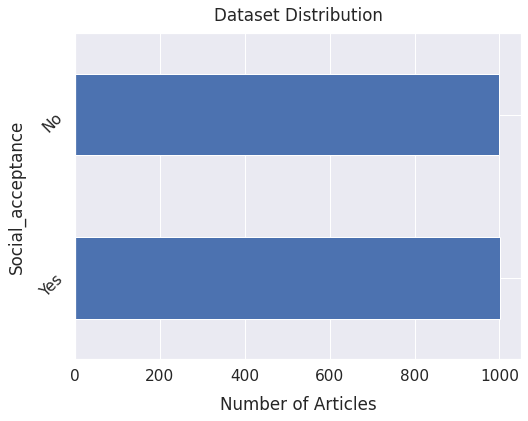

In [ ]:
# Plot the Class distribution
sns.set(font_scale=1.4)
data['Social_acceptance'].value_counts().plot(kind='barh', figsize=(8, 6))
plt.xlabel("Number of Articles", labelpad=12)
plt.ylabel("Social_acceptance", labelpad=12)
plt.yticks(rotation = 45)
plt.title("Dataset Distribution", y=1.02);

The dataset has total 12 News Categories data and politics class has maximum number of articles. 

#Data Preparation and Cleaning

In [ ]:
# Cleaning Data [Remove unncessary symbols]
def cleaning_documents(articles):
      '''
      This function will clean the news articles by removing punctuation marks and stopwords.

      Args:
      articles: a news text(str)

      returns:
      news: clean text (str)
      '''
      news = articles.replace('\n',' ')
      news = re.sub('[^\u0980-\u09FF]',' ',str(news)) #removing unnecessary punctuation
      # stopwords removal
      stp = open(dataset_path+'stopwords-bn.txt','r',encoding='utf-8').read().split()
      result = news.split()
      news = [word.strip() for word in result if word not in stp ]
      news =" ".join(news)
      return news

In [ ]:
# Apply the function into the dataframe
data['cleaned'] = data['Comment'].apply(cleaning_documents)  

In [ ]:
# print some cleaned documents from the dataset
sample_data = [2000,1200]
for i in sample_data:
  print('Original:\n',data.Comment[i],'\nCleaned:\n',
           data.cleaned[i],'\n','Social_acceptance:-- ',data.Social_acceptance[i],'\n')   

Original:
 অসাধারণ লেখা ভাই সাব। 
Cleaned:
 অসাধারণ লেখা ভাই সাব 
 Social_acceptance:--  Yes 

Original:
 হ্যাঁ, নাম নিয়ে আমিও ঝামেলায় আছি। সুযোগ পেলেই সবাই বচ্চন লাগিয়ে দেয় নামের পাশে। আর "তোর ঐশ্বরিয়া কই" জিজ্ঞেস করতে তো একটুও দ্বিধাবোধ করেনা 
Cleaned:
 হ্যাঁ নাম আমিও ঝামেলায় আছি সুযোগ পেলেই সবাই বচ্চন লাগিয়ে দেয় নামের পাশে তোর ঐশ্বরিয়া কই জিজ্ঞেস একটুও দ্বিধাবোধ করেনা 
 Social_acceptance:--  Yes 



In [ ]:
# Stopwords pickle 
stp = open(dataset_path+'stopwords-bn.txt','r',encoding='utf-8').read().split()
# open a file, where you ant to store the data
file = open(dataset_path+'bangla_stopwords.pkl', 'wb')
# dump information to that file
pickle.dump(stp, file)

In [ ]:
stp = open(dataset_path+'bangla_stopwords.pkl','rb')
stp = pickle.load(stp)
len(stp)

398

## Handle Low Length Documents

In [ ]:
# Calculate the Length of each Document
data['Length'] = data.cleaned.apply(lambda x:len(x.split()))

# Remove the Documents with least words
dataset = data.loc[data.Length>1]
dataset = dataset.reset_index(drop = True)
print("After Cleaning:","\nRemoved {} Small Documents".format(len(data)-len(dataset)),
      "\nTotal Remaining Documents:",len(dataset))

After Cleaning: 
Removed 88 Small Documents 
Total Remaining Documents: 1914


In [ ]:
# Save the Cleaned data for reuse
dataset.to_csv(dataset_path+'cleaned_news.csv')

In [ ]:
# Load the Cleaned News
dataset = pd.read_csv(dataset_path+'cleaned_news.csv')
dataset.columns

Index(['Unnamed: 0', 'No.', 'Social_acceptance', 'Comment', 'cleaned',
       'Length'],
      dtype='object')

#Document Length Distribution

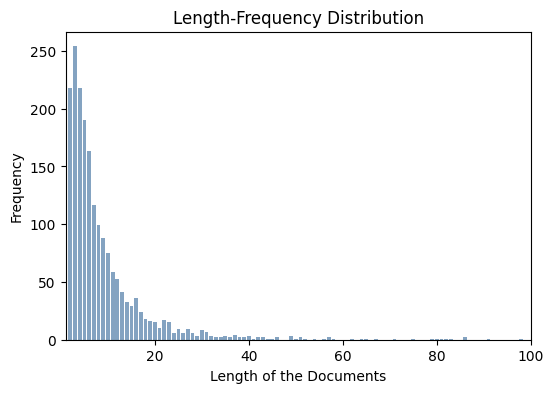

Maximum Length of a Document: 357
Minimum Length of a Document: 2
Average Length of a Document: 10.0


In [ ]:
import matplotlib
matplotlib.rc_file_defaults()
frequency = dict()
for i in dataset.Length:
    frequency[i] = frequency.get(i, 0)+1

plt.figure(figsize = (6,4))
plt.bar(frequency.keys(), frequency.values(), color=(0.2, 0.4, 0.6, 0.6))
plt.xlim(1, 100)
# in this notbook color is not working but it should work.
plt.xlabel('Length of the Documents')
plt.ylabel('Frequency')
plt.title('Length-Frequency Distribution')
#plt.savefig(path+'len_dist.png',dpi = 1000,bbox_inches ='tight')
plt.show()  
print(f"Maximum Length of a Document: {max(dataset.Length)}")
print(f"Minimum Length of a Document: {min(dataset.Length)}")
print(f"Average Length of a Document: {round(np.mean(dataset.Length),0)}")


# Dataset Summary

In [ ]:
def data_summary(dataset):
  '''
  This function will print the summary of the dataset

  Args:
  dataset: cleaned texts

  returns:
  documents: Number of document per class
  words: Number of words per class
  u_words: Number of unique words per class
  class_label: name of the categories
  '''
  documents = []
  words = []
  u_words = []
  #total_u_word = [word.strip().lower() for t in list(dataset.cleaned) for word in t.strip().split()]
  # find class names
  class_label = [k for k,v in dataset.Social_acceptance.value_counts().to_dict().items()]
  for label in class_label: 
    word_list = [word.strip().lower() for t in list(dataset[dataset.Social_acceptance==label].cleaned) for word in t.strip().split()]
    counts = dict()
    for word in word_list:
      counts[word] = counts.get(word, 0)+1
    # sort the dictionary of word list  
    ordered = sorted(counts.items(), key= lambda item: item[1],reverse = True)
    # Documents per class
    documents.append(len(list(dataset[dataset.Social_acceptance==label].cleaned)))
    # Total Word per class
    words.append(len(word_list))
    # Unique words per class 
    u_words.append(len(np.unique(word_list)))
       
    print("\nClass Name : ",label)
    print("Number of Documents:{}".format(len(list(dataset[dataset.Social_acceptance==label].cleaned))))  
    print("Number of Words:{}".format(len(word_list))) 
    print("Number of Unique Words:{}".format(len(np.unique(word_list)))) 
    print("Most Frequent Words:\n")
    for k,v in ordered[:10]:
      print("{}\t{}".format(k,v))
  return documents,words,u_words,class_label

# pass the whole dataset into the function

documents,words,u_words,class_names = data_summary(dataset)


Class Name :  Yes
Number of Documents:961
Number of Words:12626
Number of Unique Words:5033
Most Frequent Words:

ভাই	111
ভালো	83
কথা	77
নেতা	63
রহমান	60
আপনাকে	59
একটা	58
মানুষ	57
চাই	52
বাংলাদেশ	52

Class Name :  No
Number of Documents:953
Number of Words:7362
Number of Unique Words:3866
Most Frequent Words:

ভাই	63
একটা	59
ভালো	56
কথা	52
মানুষ	43
সাথে	43
এক	33
তোর	33
দিয়ে	29
টা	25


In [ ]:
data_matrix = pd.DataFrame({'Total Documents':documents,
                            'Total Words':words,
                            'Unique Words':u_words,
                            'Class Names':class_names})
data_matrix

,Total Documents,Total Words,Unique Words,Class Names
0,961,12626,5033,Yes
1,953,7362,3866,No


## Data Summary Visualization

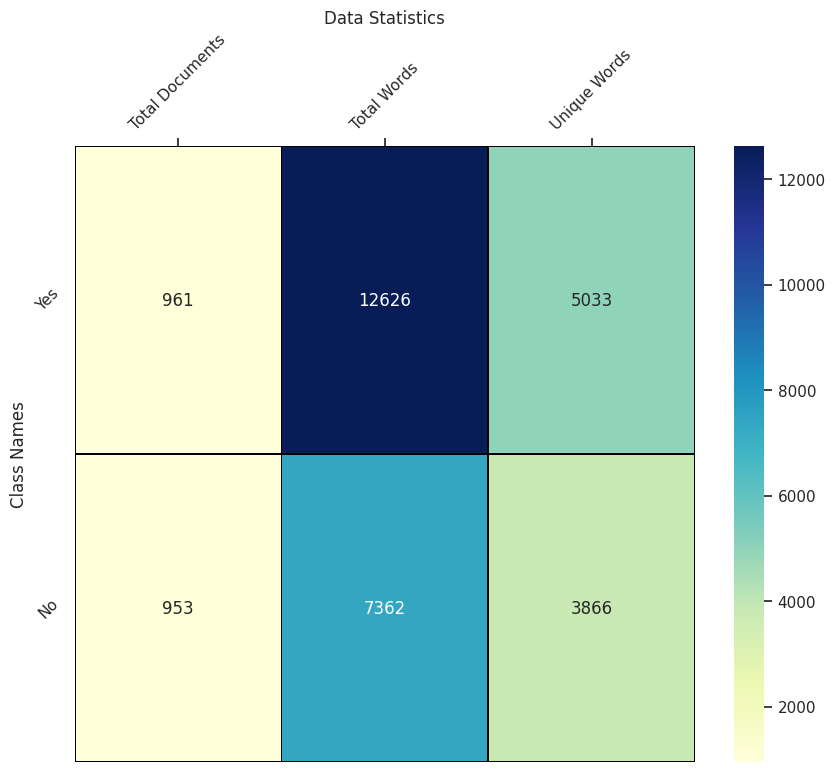

In [ ]:
sns.set()
plt.figure(figsize =(10, 8))
ax = plt.subplot()
sns.heatmap(data_matrix.iloc[:,0:3], annot=True,fmt="d", linewidths=0.5,linecolor = 'Black',cmap = "YlGnBu",ax = ax)
# labels, title and ticks
ax.set_ylabel('Class Names') 
ax.set_title('Data Statistics')
y_label = ["Total Documents", "Total Words", "Unique Words"] 
ax.xaxis.set_ticklabels(y_label, rotation=45); ax.yaxis.set_ticklabels(class_names, rotation=45);
ax.xaxis.tick_top()


#Label Encoding and Dataset Splitting

In [ ]:
                   #===========================================================
                   ################# Label Encoding Function ##################
                   #===========================================================
def label_encoding(dataset,bool):
  '''
  This function will convert categorical class names into a numeric label

  Args:
  dataset: A dataset
  bool : a boolean (True or False)

  returns:
  labels: encoded labels 
  '''
  le = LabelEncoder()
  le.fit(dataset.Social_acceptance)
  encoded_labels = le.transform(dataset.Social_acceptance)
  labels = np.array(encoded_labels) # Converting into numpy array
  class_names =le.classes_ ## Define the class names again
  if bool == True:
    print(color.BOLD+"\n\t\t\t===== Label Encoding ====="+color.END,"\nClass Names:-->",le.classes_)
  return labels  


In [ ]:
                   #===========================================================
                   ################# Dataset Splitting Function ###############
                   #=========================================================== 

def dataset_split(news,Social_acceptance):
  '''
  This function will split the dataset into Train-Test-Validation set

  Args:
  news: encoded texts
  Social_acceptance: class names

  returns:
  X_train: Encoded Training News  
  X_valid: Encoded Validation News
  X_test:  Encoded Test news
  y_train: Encoded Training labels
  y_valid: Encoded Validation labels
  y_test:  Encoded Test labels
  '''


  X_train,X_test,y_train,y_test = train_test_split(news,Social_acceptance,train_size = 0.9,
                                                  test_size = 0.1,random_state =0)
  print("Feature Size :======>",X_train.shape[1])
  print("\nDataset Distribution:\n")
  print("\tSet Name","\t\tSize")
  print("\t========\t\t======")

  print("\tFull\t\t\t",news.shape[0],
      "\n\tTraining\t\t",X_train.shape[0],
      "\n\tTest\t\t\t",X_test.shape[0])
  
  return X_train,X_test,y_train,y_test


#Tokenizer

In [ ]:
dataset['Social_acceptance'] = dataset['Social_acceptance'].astype(str)

In [ ]:
def encoded_texts(dataset,padding_length,max_words):

  '''
  This function will encoded the text into a sequence of numbers

  Args:
  dataset: a dataset
  padding_length: maximum length of a encoded texte
  max_words : Number of words 

  returns:
  corpus: Number of encoded texts
  labels: encoded labels
  '''
  
  tokenizer = Tokenizer(num_words = max_words, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n-', 
                      split=' ', char_level=False, oov_token='<oov>', document_count=0)
  
 

 # Fit the tokenizer
  tokenizer.fit_on_texts(dataset.cleaned)
  #============================== Tokenizer Info =================================
  (word_counts,word_docs,word_index,document_count) = (tokenizer.word_counts,
                                                       tokenizer.word_docs,
                                                       tokenizer.word_index,
                                                       tokenizer.document_count)
  def tokenizer_info(mylist,bool):
    ordered = sorted(mylist.items(), key= lambda item: item[1],reverse = bool)
    for w,c in ordered[:10]:
      print(w,"\t",c)
  #=============================== Print all the information =========================
  print(color.BOLD+"\t\t\t====== Tokenizer Info ======"+color.END)   
  print("Words --> Counts:")
  tokenizer_info(word_counts,bool =True )
  print("\nWords --> Documents:")
  tokenizer_info(word_docs,bool =True )
  print("\nWords --> Index:")
  tokenizer_info(word_index,bool =True )    
  print("\nTotal Documents -->",document_count)

  #=========================== Convert string into list of integer indices =================
  sequences = tokenizer.texts_to_sequences(dataset.cleaned)
  word_index = tokenizer.word_index
  print(color.BOLD+"\n\t\t\t====== Encoded Sequences ======"+color.END,"\nFound {} unique tokens".format(len(word_index)))  
  print(dataset.cleaned[10],"\n",sequences[10]) 

  #==================================== Pad Sequences ============================== 
  corpus = keras.preprocessing.sequence.pad_sequences(sequences, value=0.0,
                                                      padding='post', maxlen= padding_length)
  print("\n\t\t\t====== Paded Sequences ======\n",dataset.cleaned[10],"\n",corpus[10])   

  #=================================     Label Encoding ================================
  labels = label_encoding(dataset,True)

   # save the tokenizer into a pickle file
  with open(path+'tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

  return corpus,labels
  
#call the function
num_words = 5000
corpus,labels = encoded_texts(dataset,
                                300,num_words)
print("\nShape of Encoded Corpus =====>",corpus.shape)

			====== Tokenizer Info ======
Words --> Counts:
ভাই 	 174
ভালো 	 139
কথা 	 129
একটা 	 117
মানুষ 	 100
সাথে 	 94
আপনাকে 	 75
দিয়ে 	 73
এক 	 67
নেতা 	 65

Words --> Documents:
ভাই 	 145
ভালো 	 121
কথা 	 116
একটা 	 104
মানুষ 	 89
সাথে 	 76
আপনাকে 	 67
দিয়ে 	 61
হয়ে 	 58
চাই 	 58

Words --> Index:
এতটা 	 7602
যাকাতের 	 7601
পুজিবাদি 	 7600
সাব 	 7599
ভুগত 	 7598
অনাহারে 	 7597
বোঝানো 	 7596
পৃথিবীটা 	 7595
সবকিছুই 	 7594
অশক্ত 	 7593

Total Documents --> 1914

			====== Encoded Sequences ====== 
Found 7602 unique tokens
হেফাজতে ইসলামীর পায়ু সৈনিকরা বলবে সীমিত পরিসরে ধর্ষণ জায়েজ 
 [1657, 2774, 2775, 2776, 537, 2777, 1658, 315, 2778]

			====== Paded Sequences ======
 হেফাজতে ইসলামীর পায়ু সৈনিকরা বলবে সীমিত পরিসরে ধর্ষণ জায়েজ 
 [1657 2774 2775 2776  537 2777 1658  315 2778    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    

#Call Dataset Split Function

In [ ]:
X_train,X_test,y_train,y_test = dataset_split(corpus,labels)

Feature Size :======> 300

Dataset Distribution:

	Set Name 		Size
	========		======
	Full			 1914 
	Training		 1722 
	Test			 192


In [ ]:
model=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

In [ ]:
model.fit(X_train,y_train)

MLPClassifier()

In [ ]:
y_pred=model.predict(X_test)

In [ ]:
#DataFlair - Calculate the accuracy of our model
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)
#DataFlair - Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 64.58%


#Model Defination

In [ ]:

# embedding_dimension = 140
# input_length = 300
# vocab_size = 5000
# num_classes = 12
# batch_size = 64
# num_epochs = 10

# accuracy_threshold = 0.97


# class myCallback(keras.callbacks.Callback):
#   def on_epoch_end(self, epoch, logs={}):
#       if(logs.get('accuracy')>accuracy_threshold):
#         print("\nReached %2.2f%% accuracy so we will stop trianing" % (accuracy_threshold*100))
#         self.model.stop_training = True

# acc_callback = myCallback()
# # Saved the Best Model
# filepath = path+"Model.h5"
# checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True, 
#                                              save_weights_only=False, mode='max')
# # callback list
# callback_list = [acc_callback, checkpoint] 

#                             ###############################     CNN network architecture ################
# model = tf.keras.models.Sequential([
# tf.keras.layers.Embedding(vocab_size, embedding_dimension, input_length = input_length),
# tf.keras.layers.Conv1D(128, 5, activation= 'relu'),
# tf.keras.layers.MaxPooling1D(5),
# tf.keras.layers.Bidirectional(LSTM(64, return_sequences=True,dropout = 0.2)),
# tf.keras.layers.Bidirectional(LSTM(64, return_sequences=True,dropout = 0.2)),
# tf.keras.layers.Dense(28, activation='relu'),
# tf.keras.layers.Dense(14, activation='relu'),
# keras.layers.Flatten(),
# tf.keras.layers.Dense(num_classes , activation='softmax')])

# model.summary()

# model.compile(optimizer=keras.optimizers.Adam(),
#     loss='sparse_categorical_crossentropy',
#     metrics=['accuracy'])
   
# history = model.fit(X_train,
#     y_train,
#     epochs=num_epochs,
#     batch_size = batch_size,
#     validation_data=(X_valid, y_valid),
#     verbose =1)
#     #callbacks = callback_list)


In [ ]:
# print('CNN-BiLSTM \nAccuracy: {0:.2f}'.format(accuracy_score(y_test, y_pred)*100))

In [ ]:
# save the model
# tf.keras.models.save_model(model, path+'Document.h5', save_format='h5')
#model.save(path+'Document_Categorization.h5')

In [ ]:
# loss_values = history.history['loss']
# val_loss_values = history.history['val_loss']
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
# epochs = range(1, len(acc) + 1)
# sns.set_style('darkgrid')
#                   #=========================================================
#                   ############### Epochs vs Validation Accuracy Plot ##########
#                   #==========================================================

# plt.plot(epochs, acc, color='midnightblue', linewidth = 2, 
#           marker='o', markersize=8,label='Training Accuracy')
# plt.plot(epochs, val_acc, color='darkred', linewidth = 2, 
#           marker='o', markersize=8,label='Training Accuracy')
# plt.title('Training and validation accuracy',fontsize=12,fontweight='bold')
# # plt.xlabel('Epochs',fontsize=12,fontweight='bold')
# plt.ylabel('Accuracy',fontsize=12,fontweight='bold')
# plt.legend(['Training Accuracy','Validation Accuracy'])

From the **accuracy plot** it is observed that, the validation accuracy not improved more than 85%, it is due to multiclass imbalanced classification probelm. Moreover by proper tunning the vocabulary size the model perfoemance can be improved.

# Model Performance on Test Set

In [ ]:
# Load the saved model
# model = load_model(path+'Document.h5')

In [ ]:
# class_names = ['Yes' ,'No']
# predictions = model.predict(X_test)
# y_pred = np.argmax(predictions, axis=1)
# report = pd.DataFrame(classification_report(y_true = y_test, y_pred = y_pred, output_dict=True)).transpose()
# report = report.rename(index={'0': 'No','1':'Yes'})
# report[['precision','recall','f1-score']]=report[['precision','recall','f1-score']].apply(lambda x: round(x*100,2))
# report

By observing precision,recall and f1-score we can see that all the classes are classified reasonably well except **Art and Environment.** 

## Confusion Matrix

In [ ]:
# from sklearn.metrics import classification_report, confusion_matrix
# predictions = model.predict(X_test)
# y_pred = np.argmax(predictions, axis=1)

# cm = confusion_matrix(y_test, y_pred) 

# class_names = ['Yes' ,'No']
# # Transform to df for easier plotting
# cm_df = pd.DataFrame(cm,
#                      index = class_names, 
#                      columns = class_names)

# plt.figure(figsize=(8,6))
# sns.heatmap(cm_df, annot=True,cmap="Greens", fmt='g')
# plt.title('CNN-BiLSTM \nAccuracy: {0:.2f}'.format(accuracy_score(y_test, y_pred)*100))
# plt.ylabel('True label')
# plt.xlabel('Predicted label')
# plt.xticks(rotation = 45)
# plt.yticks(rotation = 45)
# plt.show()


The confusion matrix provides a good understanding about how many documents are correctly classified in each class and which classes get confused during classification. Here, we can see that Art, Entertainment, Politics Social_acceptance gives larger number of false classified result.  

## Test with our own news 

In [ ]:
# sample_news = 'অসভ্য মহিলা! আমি বুঝি না মানুষ কেন এদের হাইলাইট করে!'
# cleaned_news = cleaning_documents(sample_news)

# class_names = ['Yes' ,'No']

# #print(cleaned_news)
# # load the saved tokenizer
# with open(dataset_path+'tokenizer.pickle', 'rb') as handle:
#     loaded_tokenizer = pickle.load(handle)
# #print(len(loaded_tokenizer.word_index))
# seq= loaded_tokenizer.texts_to_sequences([cleaned_news])
# padded = pad_sequences(seq, value=0.0,padding='post', maxlen= 300 )
# pred = model.predict(padded)
# #print(pred) 
# class_names[np.argmax(pred)]   


In [ ]:
# # print top most classes
# y_pred = pred.reshape(-1)
# class_labels=[(class_names[i],round(prob*100,2)) for i,prob in enumerate(y_pred) if prob > 0.1]

# for k, v in class_labels:
#   print(k,'====>',v,'%')